# test Whister

Replaces AssemblyAI

In [1]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

In [2]:
# load model and processor
#processor = WhisperProcessor.from_pretrained("openai/whisper-medium")
#model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-medium")

In [42]:
import librosa
def load_audio_set_sample_rate(file_path):
    # Load the WAV file using librosa
    waveform, sample_rate = librosa.load(file_path, sr=None, mono=True)

    if not sample_rate == 16000:
        # Resample to 16kHz
        tensor_waveform = librosa.resample(waveform, orig_sr=sample_rate, target_sr=16000)
    else:
        tensor_waveform = waveform

    return tensor_waveform, 16000

# Example usage
file_path = r".\shortTestRecording.wav"
audio, sample_rate = load_audio_set_sample_rate(file_path)

print(f"File name {file_path}, {sample_rate=}, duration={audio.shape[0]/sample_rate} Sec")

File name .\shortTestRecording.wav, sample_rate=16000, duration=16.415 Sec


In [43]:
# Example usage
file_path = r".\langchain_agents_webinar.opus"
audio, sample_rate = load_audio_set_sample_rate(file_path)

print(f"File name {file_path}, {sample_rate=}, duration={audio.shape[0]/sample_rate} Sec")

File name .\langchain_agents_webinar.opus, sample_rate=16000, duration=3790.0535 Sec


In [44]:
%%time
# load model and processor

#model_name = "openai/whisper-medium"
model_name = "openai/whisper-tiny"
processor = WhisperProcessor.from_pretrained(model_name)
model = WhisperForConditionalGeneration.from_pretrained(model_name)

CPU times: total: 781 ms
Wall time: 2.35 s


In [45]:
%%time

input_features = processor(audio, sampling_rate=sample_rate, return_tensors="pt").input_features 

# generate token ids
predicted_ids = model.generate(input_features)
# decode token ids to text
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True, no_timestamps=False)
print(transcription)

[" Hello everyone. We're starting right on time because this is the most exciting webinar we've had yet. So this is the only webinar we've started on time so far, but it definitely deserves to be this one. We've got an absolutely packed webinar. Some awesome projects, some awesome people. And so we're going to have a really fun conversation. I'm going to hand it over to Charles very quickly. I just wanted to say, first of all, thank you everyone for joining."]
CPU times: total: 4.14 s
Wall time: 1.74 s


In [59]:
%%time
from tqdm.auto import tqdm

# split audio into smaller chunks
chunk_size = 16000*20 # 20 sec chunks
chunks = [audio[i:i+chunk_size] for i in range(0, len(audio), chunk_size)]

print(f"total chunks {len(chunks)}")

transcriptions = []
for index, chunk in enumerate(tqdm(chunks)):
  input_features = processor(chunk, sampling_rate=16000, return_tensors="pt").input_features

  predicted_ids = model.generate(input_features)

  transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
  #print(index, transcription)
  transcriptions.append(transcription)

full_transcription = ' '.join(transcriptions)
print("---")
print(f"Text characters number: {len(full_transcription)} and number of words {len(full_transcription.split())}")
print(full_transcription)


total chunks 190


  0%|          | 0/190 [00:00<?, ?it/s]

---


AttributeError: 'list' object has no attribute 'split'

In [ ]:
print("---")
print(f"Text characters number: {len(full_transcription)} and number of words {len(full_transcription.split())}")
print(full_transcription)

In [ ]:
## Original code with AssemblyAI results in list of transcripts in docs

URLs = [
    "https://storage.googleapis.com/aai-web-samples/langchain_agents_webinar.opus",
    "https://storage.googleapis.com/aai-web-samples/langchain_document_qna_webinar.opus",
    "https://storage.googleapis.com/aai-web-samples/langchain_retrieval_webinar.opus"
]

def create_docs(urls_list):
    l = []
    for url in urls_list:
        print(f'Transcribing {url}')
        l.append(AssemblyAIAudioTranscriptLoader(file_path=url).load()[0])
    return l
    
docs = create_docs(URLs)

In [ ]:
# https://python.langchain.com/docs/modules/data_connection/document_loaders/
from langchain.document_loaders import TextLoader

loader = TextLoader("./longText.txt")
loader.load()

## create a temporary directory for saving transcription into text files

In [79]:
import os
import tempfile

def create_temp_directory():
    # Generate a random number for the directory name
    random_number = str(hash(os.urandom(4)))
    temp_dir_name = f"tmptxt_{random_number}"

    # Create the temporary directory
    temp_dir_path = os.path.join(tempfile.gettempdir(), temp_dir_name)
    os.makedirs(temp_dir_path)

    return temp_dir_path

def write_string_to_file(directory, filename, content):
    # Create the file path within the specified directory
    file_path = os.path.join(directory, filename)

    # Write the content to the file
    with open(file_path, "w") as file:
        file.write(content)

# Example usage:
temp_dir = create_temp_directory()
string_to_save = "This is some text to save to a file."
file_name = "example.txt"
write_string_to_file(temp_dir, file_name, full_transcription)

print(f"String saved to: {os.path.join(temp_dir, file_name)}")

String saved to: C:\Users\tzurv\AppData\Local\Temp\tmptxt_-2722020173369624531\example.txt


In [107]:
# https://python.langchain.com/docs/modules/data_connection/document_loaders/
from langchain.document_loaders import TextLoader

loader = TextLoader("./longText.txt")
docs = loader.load()

In [109]:
print(type(docs[0]), type(docs[1]))

<class 'langchain.schema.document.Document'> <class 'langchain.schema.document.Document'>


In [108]:
loader1 = TextLoader(r"C:\Users\tzurv\AppData\Local\Temp\tmptxt_-2722020173369624531\example.txt")
docs.append(loader1.load()[0])

In [110]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [111]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)

texts = text_splitter.split_documents(docs)

In [112]:
print(type(texts[0]), len(texts))

<class 'langchain.schema.document.Document'> 118


# load audio

In [67]:
def whisper_transcribe(audio, *, sample_rate=16000):
    input_features = processor(audio, sampling_rate=sample_rate, return_tensors="pt").input_features 
    
    # generate token ids
    predicted_ids = model.generate(input_features)
    # decode token ids to text
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True, no_timestamps=False)
    return transcription

In [39]:
%%time
print(whisper_transcribe(audio, sample_rate=sample_rate))

ValueError: The model corresponding to this feature extractor: WhisperFeatureExtractor was trained using a sampling rate of 16000. Please make sure that the provided `raw_speech` input was sampled with 16000 and not 48000.

In [ ]:
import soundfile as sf
# Download audio file from link
url = "https://storage.googleapis.com/aai-web-samples/langchain_agents_webinar.opus"
response = requests.get(url)

# Convert response to NumPy array
audio_bytes = BytesIO(response.content)

data, samplerate = sf.read(audio_bytes.read())

In [7]:
import requests 
import numpy as np
from io import BytesIO

# Download audio file from link
url = "https://storage.googleapis.com/aai-web-samples/langchain_agents_webinar.opus"
response = requests.get(url)

# Convert response to NumPy array
audio_bytes = BytesIO(response.content)
data = audio_bytes.read()

# Round down to multiple of 2 
buffer_size = len(data) - len(data) % 2 

audio_array = np.frombuffer(data[:buffer_size], dtype=np.int16)

print(type(audio_array))

<class 'numpy.ndarray'>


In [21]:
import librosa
import soundfile as sf
import requests
from io import BytesIO

# Download audio file from link
url = "https://storage.googleapis.com/aai-web-samples/langchain_agents_webinar.opus"
response = requests.get(url)

# Convert response to BytesIO object
audio_bytes = BytesIO(response.content)

# Read audio using librosa
y, sr = librosa.load(audio_bytes, sr=None)

# Now, y is a numpy array containing the audio data, and sr is the sample rate.


In [ ]:
import soundfile as sf
import requests
from io import BytesIO

# Download audio file from the link
url = "https://storage.googleapis.com/aai-web-samples/langchain_agents_webinar.opus"
response = requests.get(url, stream=True)

# Create an empty list to store audio data
data = []

with BytesIO() as audio_bytes:
    for chunk in response.iter_content(chunk_size=1024):
        audio_bytes.write(chunk)
        audio_bytes.seek(0)
        partial_data, samplerate = sf.read(audio_bytes.read())
        data.extend(partial_data)

In [36]:
print(audio.shape, sample_rate)

(181922568,) 48000


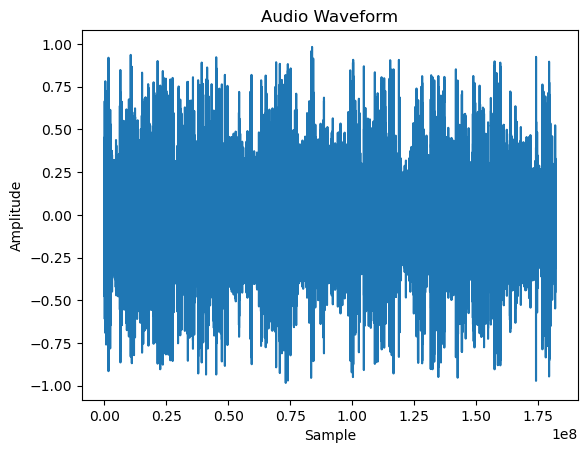

In [32]:
import matplotlib.pyplot as plt

# Plot audio 
plt.plot(audio)
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.title("Audio Waveform")
plt.show()
